Target: Minimal tour length is: 
- kroA100: 21282
- att48: 10628
- fri26: 937

In [1]:
import tsplib95

problem = tsplib95.load('att48.tsp')
dimension = problem.dimension
nodes = list(problem.get_nodes())
print(dimension)
print(nodes)

48
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [3]:
def total_distance(tour):
    distance = 0
    for i in range(len(tour) - 1):
        distance += problem.get_weight(tour[i], tour[i + 1])
    distance += problem.get_weight(tour[-1], tour[0])  # kembali ke kota awal
    return distance

# Contoh penggunaan
example = list(problem.get_nodes())
print("Contoh rute:", example)
print("Total jarak:", total_distance(example))

Contoh rute: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
Total jarak: 49840


In [4]:
def swap_two(tour, i, j): # red
    new = tour[:]
    if j - i < 4:
        return interchange(new, i, j)

    mid = new[i:j+1]
    k = len(mid) // 2
    seg1 = mid[:k]
    seg2 = mid[k:]
    new[i:i+k] = seg2
    new[i+k:j+1] = seg1
    return new

def flip(tour, i, j): # peach
    new = tour[:]
    new[i:j+1] = reversed(new[i:j+1])
    return new

def interchange(tour, i, j): # green
    new = tour[:]
    new[i], new[j] = new[j], new[i]
    return new

def slide(tour, i, j): # yellow
    new = tour[:]
    city = new.pop(i)
    new.insert(j, city)
    return new

def guided_swap(tour, i, j): # blue
    new = flip(tour, i, j)
    return interchange(new, i, j)

def scramble(tour): # gray
    new = tour[:]
    random.shuffle(new)
    return new

In [11]:
def lovebird(pop_size=25, max_gen=25):
    population = [random.sample(nodes, dimension) for _ in range(pop_size)]
    global_best = min(population, key=total_distance)
    history = [total_distance(global_best)]

    stagnation = 0

    for g in range(max_gen):
        new_candidates = []

        for _ in range(pop_size):
            S = random.choices(population, weights=[1 / total_distance(p) for p in population])[0]
            S = copy.deepcopy(S)

            if random.random() < 0.9:
                i, j = sorted(random.sample(range(dimension), 2))
                a = random.randint(1, 5)
                if a == 1:
                    candidate = swap_two(S, i, j)
                elif a == 2:
                    candidate = flip(S, i, j)
                elif a == 3:
                    candidate = interchange(S, i, j)
                elif a == 4:
                    candidate = slide(S, i, j)
                elif a == 5:
                    candidate = guided_swap(S, i, j)
            else:
                candidate = scramble(S)

            new_candidates.append(candidate)

        crn_best = min(new_candidates, key=total_distance)
        if total_distance(crn_best) < total_distance(global_best):
            global_best = crn_best
        else:
            # UPDATE 7
            improved = True
            ls_sol = global_best[:]

            while improved:
                improved = False

                # Step 1: Swap
                for i in range(dimension - 1):
                    for j in range(i + 1, dimension):
                        candidate = swap_two(ls_sol, i, j)
                        if total_distance(candidate) < total_distance(ls_sol):
                            ls_sol = candidate
                            improved = True
                            break
                    if improved:
                        break

                if improved:
                    continue  # Ulangi dari swap lagi

                # Step 2: Flip
                for i in range(dimension - 1):
                    for j in range(i + 1, dimension):
                        candidate = flip(ls_sol, i, j)
                        if total_distance(candidate) < total_distance(ls_sol):
                            ls_sol = candidate
                            improved = True
                            break
                    if improved:
                        break

            if total_distance(ls_sol) < total_distance(global_best):
                global_best = ls_sol
                stagnation = 0
            else:
                stagnation += 1

        if stagnation >= 5:
            break

        history.append(total_distance(global_best))
        population = sorted(new_candidates, key=total_distance)[:pop_size]

    return global_best, total_distance(global_best), history

In [12]:
best_tour_a, best_cost_a, history_a = lovebird()

print("Best distance found:", best_cost_a)

Best distance found: 10932


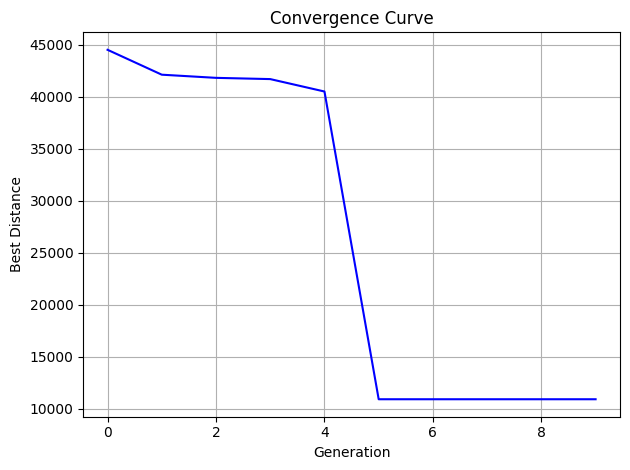

In [13]:
import matplotlib.pyplot as plt

plt.plot(history_a, linestyle='-', color='blue')
plt.title("Convergence Curve")
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
def localized_lovebird(initial_solution=None, generations=500, stagnation_limit=50, local_search_checks=50):
    if initial_solution is None:
        current = random.sample(nodes, dimension)
    else:
        current = initial_solution[:]
    global_best = current[:]
    best_cost = total_distance(global_best)
    stagnation = 0
    history = [best_cost]

    for _ in range(generations):
        i, j = sorted(random.sample(range(dimension), 2))
        move = random.choice([swap_two, flip, interchange, slide, guided_swap])
        candidate = move(current[:], i, j)
        candidate_cost = total_distance(candidate)

        if candidate_cost < best_cost:
            global_best = candidate
            best_cost = candidate_cost
            current = candidate
            stagnation = 0
        else:
            ls_sol = global_best[:]
            ls_cost = best_cost
            for _ in range(local_search_checks):
                i, j = sorted(random.sample(range(dimension), 2))
                trial = flip(ls_sol[:], i, j)
                trial_cost = total_distance(trial)
                if trial_cost < ls_cost:
                    ls_sol, ls_cost = trial, trial_cost

            if ls_cost < best_cost:
                global_best = ls_sol
                best_cost = ls_cost
                current = ls_sol
                stagnation = 0
            else:
                stagnation += 1
                if stagnation >= stagnation_limit:
                    break

        history.append(best_cost)

    return global_best, best_cost, history

In [91]:
best_tour_b, best_cost_b, history_b = localized_lovebird()
print("Best distance found:", best_cost_b)

Best distance found: 11292


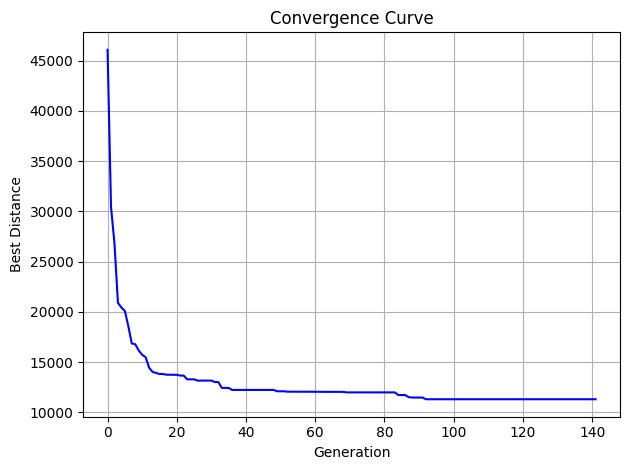

In [92]:
plt.plot(history_b, linestyle='-', color='blue')
plt.title("Convergence Curve")
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def heavy_scramble(tour, num_cities=6):
    new = tour[:]
    i = random.randint(0, len(tour) - num_cities)
    sub = new[i:i+num_cities]
    random.shuffle(sub)
    return new[:i] + sub + new[i+num_cities:]


def iterated_lovebird(max_iter=30, local_gen=200, stagnation_limit=50, local_checks=50, stop_iter=10):
    current = random.sample(nodes, dimension)
    best_sol, best_cost, _ = localized_lovebird(
        current, generations=local_gen, stagnation_limit=stagnation_limit, local_search_checks=local_checks
    )

    history = [best_cost]

    stagnation = 0

    for _ in range(max_iter):
        perturbed = heavy_scramble(best_sol[:])

        improved_sol, improved_cost, _ = localized_lovebird(
            perturbed, generations=local_gen, stagnation_limit=stagnation_limit, local_search_checks=local_checks
        )

        if improved_cost < best_cost:
            best_sol = improved_sol
            best_cost = improved_cost
            stagnation = 0
        else:
            stagnation += 1
            if stagnation >= stop_iter:
                break

        history.append(best_cost)

    # FINAL POLISH STEP (was missing)
    best_sol, best_cost, _ = localized_lovebird(
        best_sol, generations=300, stagnation_limit=100, local_search_checks=100
    )

    history.append(best_cost)

    return best_sol, best_cost, history


In [130]:
best_tour_c, best_cost_c, history_c = iterated_lovebird()
print("Best distance found:", best_cost_c)

Best distance found: 10736


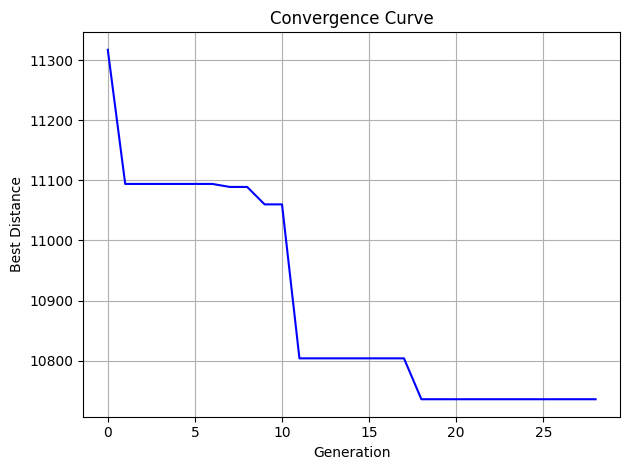

In [131]:
plt.plot(history_c, linestyle='-', color='blue')
plt.title("Convergence Curve")
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
import optuna
import time

# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    max_iter = trial.suggest_int("max_iter", 15, 25)
    local_gen = trial.suggest_int("local_gen", 60, 65)
    stagnation_limit = trial.suggest_int("stagnation_limit", 10, 20)
    local_checks = trial.suggest_int("local_checks", 55, 65)

    start_time = time.time()

    # Run the algorithm
    _, best_cost, _ = iterated_lovebird(
        max_iter=max_iter,
        local_gen=local_gen,
        stagnation_limit=stagnation_limit,
        local_checks=local_checks
    )

    end_time = time.time()
    duration = end_time - start_time

    if duration > 30:
        raise optuna.exceptions.TrialPruned("Trial took too long")

    return best_cost, duration

# Create and run Optuna study
study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective, n_trials=50)

best = study.best_trials[0]
# Print best result
print("Best Parameters:")
print(best.params)
print("Best Cost:")
print(best.values)

[I 2025-07-17 15:50:52,417] A new study created in memory with name: no-name-0822122c-0b74-45ae-9af7-06cad585ba1c
[I 2025-07-17 15:51:06,485] Trial 0 finished with values: [10963.0, 14.066420555114746] and parameters: {'max_iter': 15, 'local_gen': 63, 'stagnation_limit': 12, 'local_checks': 65}.
[I 2025-07-17 15:51:40,129] Trial 1 pruned. Trial took too long
[I 2025-07-17 15:52:40,219] Trial 2 pruned. Trial took too long
[I 2025-07-17 15:53:53,734] Trial 3 pruned. Trial took too long
[I 2025-07-17 15:55:16,443] Trial 4 pruned. Trial took too long
[I 2025-07-17 15:55:37,305] Trial 5 finished with values: [10930.0, 20.86051297187805] and parameters: {'max_iter': 22, 'local_gen': 63, 'stagnation_limit': 15, 'local_checks': 62}.
[I 2025-07-17 15:55:50,022] Trial 6 finished with values: [11063.0, 12.715455770492554] and parameters: {'max_iter': 20, 'local_gen': 64, 'stagnation_limit': 10, 'local_checks': 55}.
[I 2025-07-17 15:56:22,586] Trial 7 pruned. Trial took too long
[I 2025-07-17 15:5

Best Parameters:
{'max_iter': 15, 'local_gen': 63, 'stagnation_limit': 10, 'local_checks': 65}
Best Cost:
[10738.0, 11.187760591506958]


In [61]:
df = study.trials_dataframe()
print(df[["params_max_iter", "params_local_gen", "params_stagnation_limit", "params_local_checks", "values_0", "values_1"]])

    params_max_iter  params_local_gen  params_stagnation_limit  \
0                15                63                       12   
1                15                63                       11   
2                20                62                       15   
3                19                65                       18   
4                24                65                       20   
5                22                63                       15   
6                20                64                       10   
7                19                62                       12   
8                15                60                       14   
9                19                65                       10   
10               16                63                       15   
11               15                63                       19   
12               21                62                       17   
13               25                63                       20   
14        

In [132]:
import time

N = 20
results_original = []
results_llb = []
results_ilb = []

runtimes_original = []
runtimes_llb = []
runtimes_ilb = []

for _ in range(N):
    random.seed(_)

    # Run Lovebird
    start = time.time()
    _, cost1, _ = lovebird()
    end = time.time()
    results_original.append(cost1)
    runtimes_original.append(end - start)

    # Run Localized Lovebird
    start = time.time()
    _, cost2, _ = localized_lovebird()
    end = time.time()
    results_llb.append(cost2)
    runtimes_llb.append(end - start)

    # Run Iterated Lovebird
    start = time.time()
    _, cost3, _ = iterated_lovebird()
    end = time.time()
    results_ilb.append(cost3)
    runtimes_ilb.append(end - start)

C:\Users\Raditya\AppData\Local\Temp\ipykernel_24856\3174447299.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


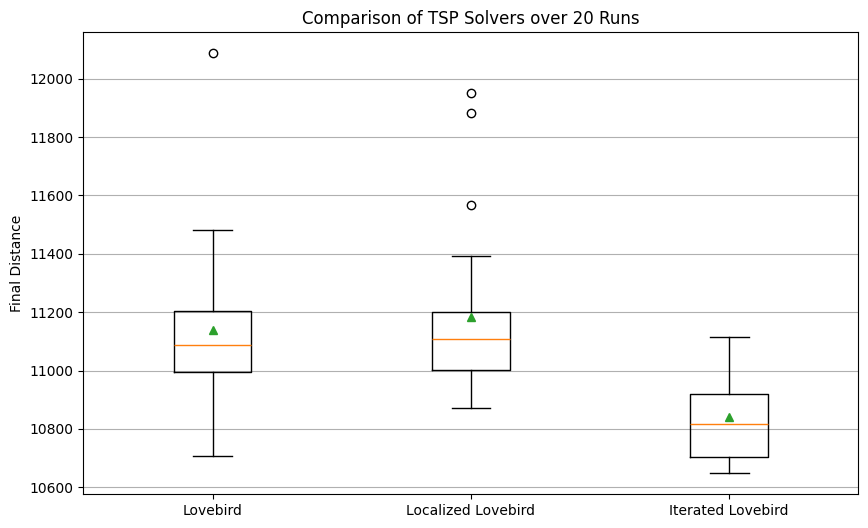

In [133]:
# Plot boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(
    [results_original, 
     results_llb, 
     results_ilb],
    labels=["Lovebird", 
            "Localized Lovebird", 
            "Iterated Lovebird"],
    showmeans=True
)
plt.title(f"Comparison of TSP Solvers over {N} Runs")
plt.ylabel("Final Distance")
plt.grid(axis="y")
plt.show()

C:\Users\Raditya\AppData\Local\Temp\ipykernel_24856\2129998898.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([runtimes_original, runtimes_llb, runtimes_ilb], labels=["Lovebird", "Localized Lovebird", "Iterated Lovebird"], showmeans=True)


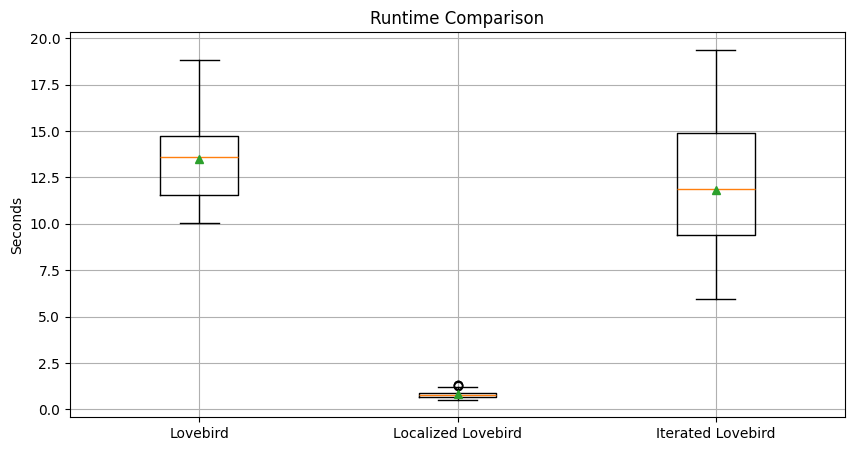

In [134]:
plt.figure(figsize=(10, 5))
plt.boxplot([runtimes_original, runtimes_llb, runtimes_ilb], labels=["Lovebird", "Localized Lovebird", "Iterated Lovebird"], showmeans=True)
plt.title("Runtime Comparison")
plt.ylabel("Seconds")
plt.grid(True)
plt.show()

In [135]:
def print_stats(name, results):
    print(f"{name:<10} | Min: {min(results):>7.2f} | Max: {max(results):>7.2f} | "
          f"Mean: {np.mean(results):>7.2f} | Std: {np.std(results):>7.2f}")

print_stats("Lovebird", results_original)
print_stats("Localized Lovebird", results_llb)
print_stats("Iterated Lovebird", results_ilb)

print("---------------------------------------------------------")

print_stats("Lovebird", runtimes_original)
print_stats("Localized Lovebird", runtimes_llb)
print_stats("Iterated Lovebird", runtimes_ilb)

Lovebird   | Min: 10707.00 | Max: 12087.00 | Mean: 11137.60 | Std:  284.52
Localized Lovebird | Min: 10872.00 | Max: 11952.00 | Mean: 11183.70 | Std:  294.27
Iterated Lovebird | Min: 10648.00 | Max: 11115.00 | Mean: 10841.25 | Std:  143.15
---------------------------------------------------------
Lovebird   | Min:   10.06 | Max:   18.85 | Mean:   13.49 | Std:    2.39
Localized Lovebird | Min:    0.52 | Max:    1.31 | Mean:    0.84 | Std:    0.24
Iterated Lovebird | Min:    5.97 | Max:   19.38 | Mean:   11.84 | Std:    3.77


<h3>PERSONAL REPORT:</h3>

**[Update #1 - Added Local Evaluator in the Lovebird Algorithm]**
> Enhanced the hill climbing phase by implementing a local comparator to evaluate and retain only better neighboring routes.
- Positive: Results improved significantly in terms of total distance.
- Negative: Slight increase in runtime due to evaluation overhead.
- Conclusion: Continue with this local evaluation mechanism in future iterations.

**[Update #2 - Localizing the Lovebird Algorithm (Population Removed)]**
> Transformed the Lovebird Algorithm into a localized version by removing population and focusing on a single solution evolution.
- Positive: Achieved better results with less memory usage, and runtime remained efficient even with higher iteration counts.
- Negative: Solution quality appears to be more sensitive to the choice of the initial tour.
- Conclusion: This version will serve as the local search core in a hybrid structure with a global search mechanism.

**[Update #3 - Perturbation via Randomized Mutation (ILS Integration)]**
> Integrated the Localized Lovebird into an Iterated Local Search (ILS) framework. Perturbation applied via random mutation operators drawn from the original algorithm to preserve its identity.
- Positive: Produced more consistent and improved results across multiple runs.
- Negative: Significant increase in runtime (from ~10 seconds to nearly 2 minutes).
- Conclusion: Effectiveness proven, but runtime cost needs evaluation or optimization.

**[Update #4 - Added Early Stop to the Localized Lovebird Algorithm]**
> As a solution for the runtime, early stop is added in the localized version.
- Positive: Significantly reduced the runtime for localized (10s to 2s) and hybrid version (2 mins to 1 min).
- Negative: Slight increase in result variance in the localized version. In the hybrid version, the variance increase is minimal and acceptable
- Conclusion: The early stop mechanism provides a good balance between efficiency and performance. Keep early stop active for future experiments.

**[Update #5 - Changed the Iterations from 50 to 30 and Generations from 200 to 300]**
> For the sake of shortening the runtime of the Iterating Lovebird Algorithm.
- Positive: Significantly reduced the runtime from 1-2 mins to 30 secs.
- Negative: Increased the result variance and gave slightly worse results than previous.
- Conclusion: Change the approach.

**[Update #6 - Major Tweak on Localized and Iterated]**
> Change the swap to flip in the localized, making it a bit extreme on the changes but still managable. Added heavy_scramble function for richer and controlled perturbation. Added last touch of local search after the iterations ended.
- Positive: Better performance and managed to get extremely close to the ideal solution.
- Negative: Slightly increased runtime by 5-7 secs.
- Conclusion: Done for now. Time to compare with other standard algorithms.

**[Update #7 - Major Tweak on All Algorithms]**
> Added two intensive searches and erase max_loop and changed it to "until improved" condition in the Lovebird Algorithm. Adapt the same method in the Localized, but still use max_loop to reduce runtime. Change the value of the parameters in the ILB and erased the last local at the end of the iteration.
- Positive: 
- Negative: 
- Conclusion: 

In [17]:
def genetic_algorithm(pop_size=200, generations=1000, mutation_rate=0.1):
    population = [random.sample(nodes, dimension) for _ in range(pop_size)]

    def crossover(p1, p2):
        start, end = sorted(random.sample(range(dimension), 2))
        child = p1[start:end+1]
        child += [c for c in p2 if c not in child]
        return child

    def mutate(route):
        if random.random() < mutation_rate:
            i, j = sorted(random.sample(range(dimension), 2))
            route[i], route[j] = route[j], route[i]
        return route

    best = min(population, key=total_distance)
    history = [total_distance(best)]

    for _ in range(generations):
        new_population = []
        population.sort(key=total_distance)
        elites = population[:pop_size // 2]
        for _ in range(pop_size):
            parents = random.sample(elites, 2)
            child = crossover(parents[0], parents[1])
            child = mutate(child)
            new_population.append(child)
        population = new_population
        current_best = min(population, key=total_distance)
        if total_distance(current_best) < total_distance(best):
            best = current_best
        history.append(total_distance(best))

    return best, total_distance(best), history

In [18]:
best_solution_ga, best_cost_ga, history_ga = genetic_algorithm()
print("Best distance found by GA:", best_cost_ga)

Best distance found by GA: 20894


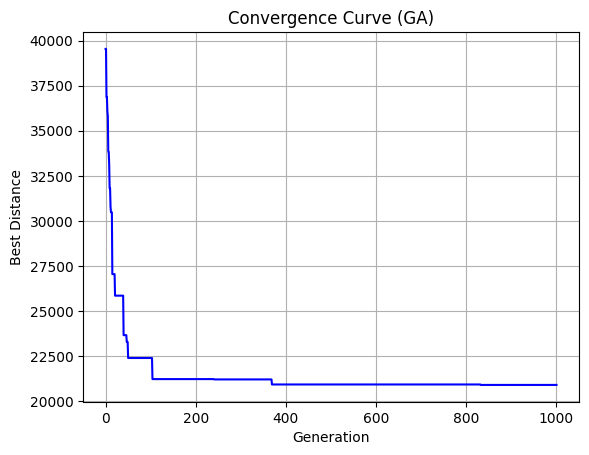

In [19]:
plt.plot(history_ga, linestyle='-', color='blue')
plt.title("Convergence Curve (GA)")
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.grid(True)
plt.show()

In [20]:
def simulated_annealing(
    initial_temp=1000,
    min_temp=0.001,
    cooling_rate=0.995
):
    current = random.sample(nodes, dimension)
    best = current[:]
    best_cost = total_distance(best)
    current_cost = best_cost
    temp = initial_temp
    history = [best_cost]

    while temp > min_temp:
        # Generate neighbor by flipping 2 cities
        i, j = sorted(random.sample(range(dimension), 2))
        candidate = flip(current, i, j)
        candidate_cost = total_distance(candidate)
        delta = candidate_cost - current_cost

        if delta < 0 or random.random() < np.exp(-delta / temp):
            current = candidate
            current_cost = candidate_cost
            if current_cost < best_cost:
                best = current[:]
                best_cost = current_cost

        history.append(best_cost)
        temp *= cooling_rate

    return best, best_cost, history

In [21]:
best_solution_sa, best_cost_sa, history_sa = simulated_annealing()
print("Best distance found by SA:", best_cost_sa)

Best distance found by SA: 12049


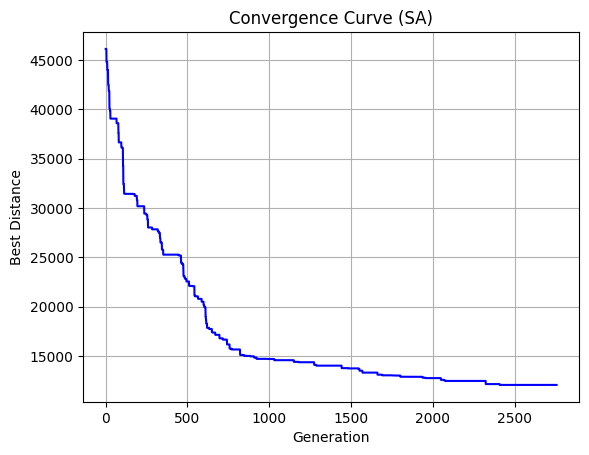

In [22]:
plt.plot(history_sa, linestyle='-', color='blue')
plt.title("Convergence Curve (SA)")
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.grid(True)
plt.show()

In [23]:
def ant_colony_optimization(
    n_ants=50, n_best=5, n_iterations=900, decay=0.1, alpha=1, beta=3
):
    id_to_index = {node: i for i, node in enumerate(nodes)}
    index_to_id = {i: node for i, node in enumerate(nodes)}

    pheromone = np.ones((dimension, dimension))
    distances = np.array([[problem.get_weight(i, j) for j in nodes] for i in nodes])
    visibility = 1 / (distances + np.eye(dimension))  # avoid div by zero
    np.fill_diagonal(visibility, 0)

    best_distance = float('inf')
    best_tour = None
    history = []

    for _ in range(n_iterations):
        all_tours = []
        all_lengths = []

        for _ in range(n_ants):
            tour = []
            unvisited = nodes[:]
            current = random.choice(unvisited)
            tour.append(current)
            unvisited.remove(current)

            while unvisited:
                current_idx = id_to_index[current]
                probs = []
                for j in unvisited:
                    j_idx = id_to_index[j]
                    pher = pheromone[current_idx][j_idx] ** alpha
                    vis = visibility[current_idx][j_idx] ** beta
                    probs.append(pher * vis)
                probs = np.array(probs)
                probs /= probs.sum()
                next_city = random.choices(unvisited, weights=probs)[0]
                tour.append(next_city)
                unvisited.remove(next_city)
                current = next_city

            all_tours.append(tour)
            length = total_distance(tour)
            all_lengths.append(length)

            if length < best_distance:
                best_distance = length
                best_tour = tour

        # Update pheromone
        pheromone *= (1 - decay)
        sorted_indices = np.argsort(all_lengths)
        for i in sorted_indices[:n_best]:
            tour = all_tours[i]
            for j in range(dimension - 1):
                a, b = id_to_index[tour[j]], id_to_index[tour[j+1]]
                pheromone[a][b] += 1.0 / all_lengths[i]
            # Loop closure
            a, b = id_to_index[tour[-1]], id_to_index[tour[0]]
            pheromone[a][b] += 1.0 / all_lengths[i]

        history.append(best_distance)

    return best_tour, best_distance, history

In [24]:
best_solution_aco, best_cost_aco, history_aco = ant_colony_optimization()
print("Best distance found by ACO:", best_cost_aco)

Best distance found by ACO: 10774


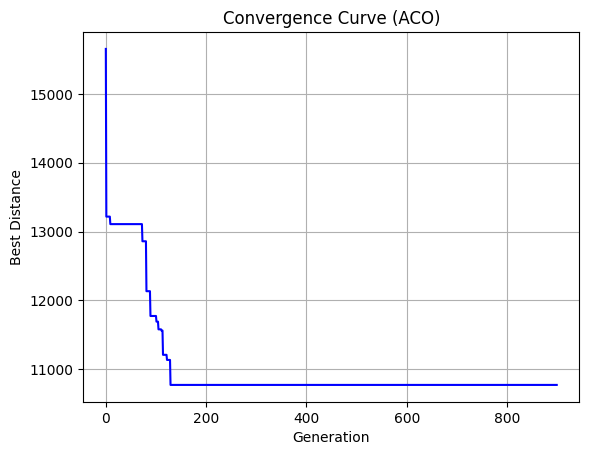

In [25]:
plt.plot(history_aco, linestyle='-', color='blue')
plt.title("Convergence Curve (ACO)")
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.grid(True)
plt.show()

In [26]:
results_ga = []
results_sa = []
results_aco = []

for _ in range(N):
    # Run GA
    _, costga, _ = genetic_algorithm()
    results_ga.append(costga)

    # # Run SA
    _, costsa, _ = simulated_annealing()
    results_sa.append(costsa)

    # Run ACO
    _, costaco, _ = ant_colony_optimization()
    results_aco.append(costaco)


C:\Users\Raditya\AppData\Local\Temp\ipykernel_10856\2294426736.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


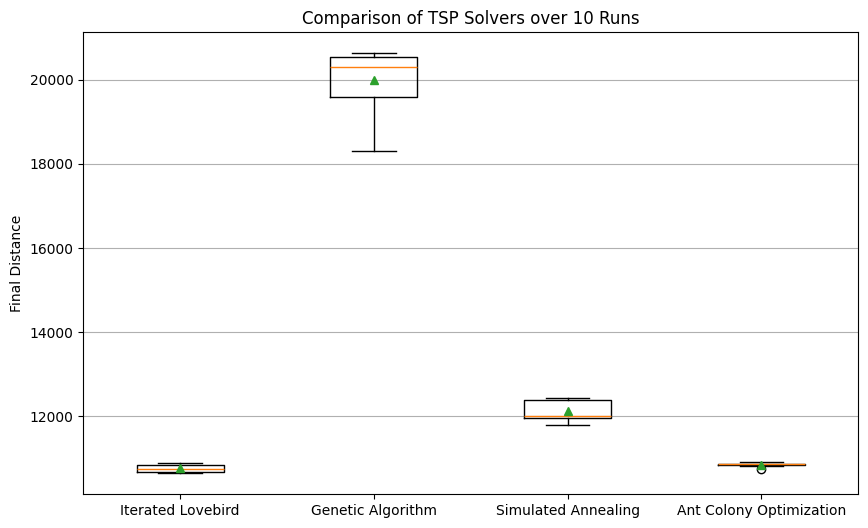

In [29]:
# Plot boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(
    [results_ilb,
     results_ga, 
     results_sa,
     results_aco
    ],
    labels=["Iterated Lovebird", 
            "Genetic Algorithm",
            "Simulated Annealing",
            "Ant Colony Optimization"
            ],
    showmeans=True
)
plt.title(f"Comparison of TSP Solvers over {N} Runs")
plt.ylabel("Final Distance")
plt.grid(axis="y")
plt.show()

In [30]:
def print_stats(name, results):
    print(f"{name:<10} | Min: {min(results):>7.2f} | Max: {max(results):>7.2f} | "
          f"Mean: {np.mean(results):>7.2f} | Std: {np.std(results):>7.2f}")

print_stats("Iterated Lovebird", results_ilb)
print_stats("Genetic Algorithm", results_ga)
print_stats("Simulated Annealing", results_sa)
print_stats("Ant Colony Optimization", results_aco)

Iterated Lovebird | Min: 10648.00 | Max: 10894.00 | Mean: 10765.30 | Std:   87.29
Genetic Algorithm | Min: 18300.00 | Max: 20626.00 | Mean: 19992.90 | Std:  718.82
Simulated Annealing | Min: 11803.00 | Max: 12443.00 | Mean: 12118.20 | Std:  236.54
Ant Colony Optimization | Min: 10738.00 | Max: 10921.00 | Mean: 10849.70 | Std:   45.06


In [31]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def create_data_model():
    matrix = [[problem.get_weight(i, j) for j in nodes] for i in nodes]
    return {
        'distance_matrix': matrix,
        'num_vehicles': 1,
        'depot': 0,
    }

def solve_tsp_with_ortools():
    data = create_data_model()

    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']),
        data['num_vehicles'],
        data['depot']
    )

    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # First solution strategy: GREEDY + LOCAL_SEARCH metaheuristics
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 5  # Bisa diubah

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        index = routing.Start(0)
        plan = []
        while not routing.IsEnd(index):
            plan.append(nodes[manager.IndexToNode(index)])
            index = solution.Value(routing.NextVar(index))
        plan.append(nodes[manager.IndexToNode(index)])  # return to depot

        cost = solution.ObjectiveValue()
        return plan, cost
    else:
        print("No solution found!")
        return None, float('inf')

In [32]:
ortools_tour, ortools_cost = solve_tsp_with_ortools()
print("OR-Tools Best Distance:", ortools_cost)
print("Route:", ortools_tour)

OR-Tools Best Distance: 10628
Route: [1, 8, 38, 31, 44, 18, 7, 28, 6, 37, 19, 27, 17, 43, 30, 36, 46, 33, 20, 47, 21, 32, 39, 48, 5, 42, 24, 10, 45, 35, 4, 26, 2, 29, 34, 41, 16, 22, 3, 23, 14, 25, 13, 11, 12, 15, 40, 9, 1]
